# V0 Algo - Evaluating the performance of our retrieval algorithm

And the resulting taxonomy it creates.

In [24]:
import os 
import sys 
import networkx as nx
import matplotlib as mpl
import numpy as np
import pprint
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import random

from sentence_transformers import SentenceTransformer
# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.etl import embedding_funcs, etl_funcs
from src.algorithms import v0, v1, v3, v4
from src.evaluation import graph_scoring, output_funcs
from src.processing import graph_construction

In [2]:
# Load the document index
document_index = etl_funcs.load_documents()

# Embed the document index
embedded_index = embedding_funcs.embed_index(document_index)

Embedding Documents: 100%|██████████| 197/197 [00:07<00:00, 26.19it/s]


# V0 Algorithm

In [3]:
# Create the adjacency matrix
adj_matrix = graph_construction.construct_adjacency_dict(
    embedded_index,
    v0.V0Retriever()
)

# Create the graph from teh adjacency matrix
graph = graph_construction.construct_graph_from_adj_dict(
    adj_matrix,
    0.55,
    embedded_index
)

Constructing adjacency dict: 100%|██████████| 197/197 [00:05<00:00, 33.39it/s]


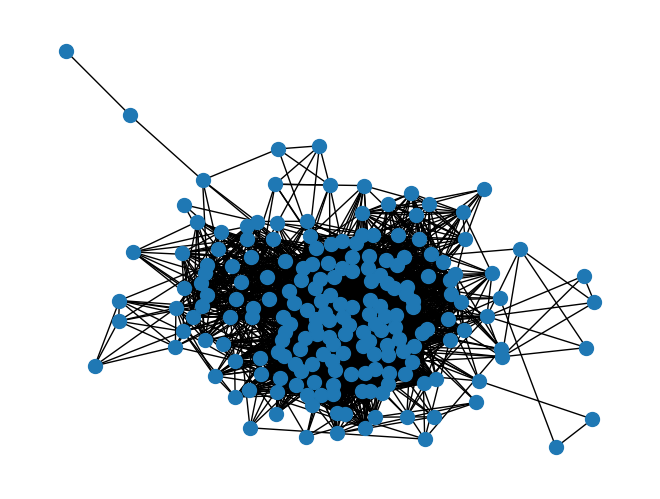

In [4]:
# Visualise the generated graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)

In [5]:
# Evaluate the graph
graph_eval = graph_scoring.quick_stats(graph)

# View the results without the communities (as its long)
{k: v for k, v in graph_eval.items() if k != 'communities'}

Calculating quick stats


{'number_of_nodes': 197,
 'number_of_edges': 4547,
 'average_degree': 46.16243654822335,
 'density': 0.23552263545011914,
 'clustering_coefficient': 0.642271837232539}

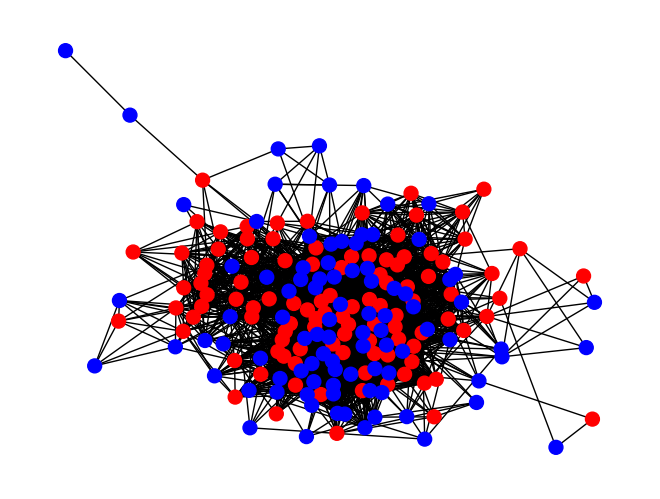

In [6]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in graph.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=colors)

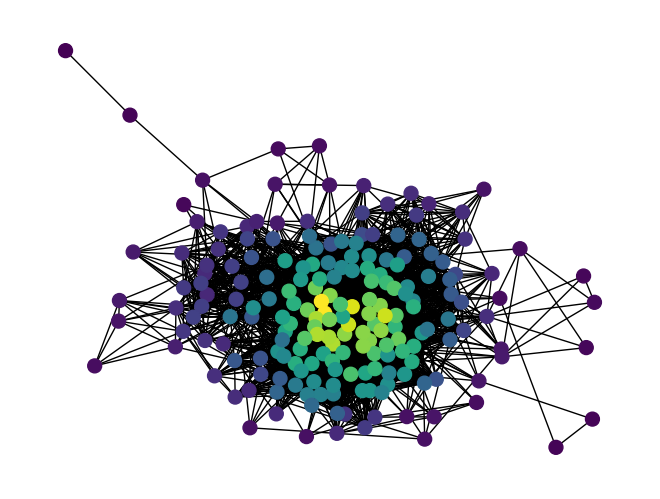

In [7]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=color_map)

## Evaluating the detected communities

In [8]:
try:
    graph_eval['communities']

    community_node_list = graph_eval['communities']

    # Split viridis into n colors
    n = len(community_node_list)
    viridis = mpl.colormaps['viridis']
    colors = [viridis(i/n) for i in range(n)]

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in graph.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(graph)
    nx.draw(graph, pos, node_size=100, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", graph_eval['community_modularity'])

    # Do some evaluation for each of the communities detected.
    for com_nodes in community_node_list:
        subgraph = graph.subgraph(com_nodes)
        subgraph_eval = graph_scoring.simple_stats(subgraph)
        subgraph_eval2 = graph_scoring.attribute_stats(subgraph)
        
        pprint.pprint(subgraph_eval)
        pprint.pprint(subgraph_eval2)
        
        print("-------------------")
        
except KeyError:
    pass

# V1 algorithm Graph Eval
1. Write the code to create the graph in a more efficient way
2. This is using a dict-of-dicts approach - the pure python approach to an adjacency matrix.

In [3]:
# Calc the adj dict.
adj_dict = graph_construction.construct_adjacency_dict(embedded_index, v1.V1Retriever())


Constructing adjacency dict: 100%|██████████| 197/197 [00:39<00:00,  5.00it/s]


In [10]:
# Construct the graph
graph2 = graph_construction.construct_graph_from_adj_dict(adj_dict, 0.96, embedded_index)

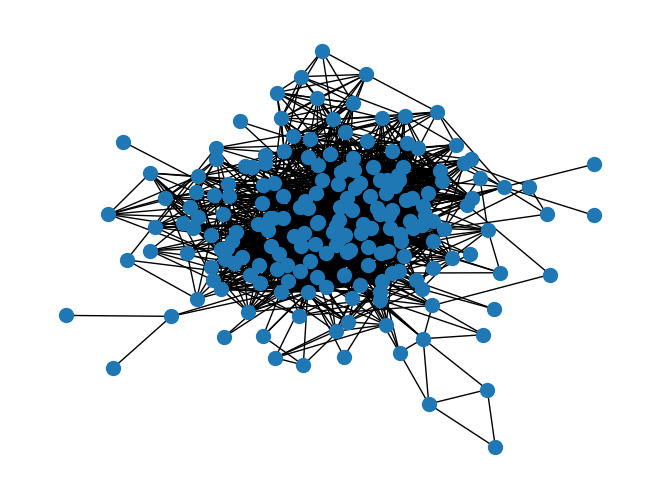

In [11]:
pos_test_G = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos_test_G, node_size=100)

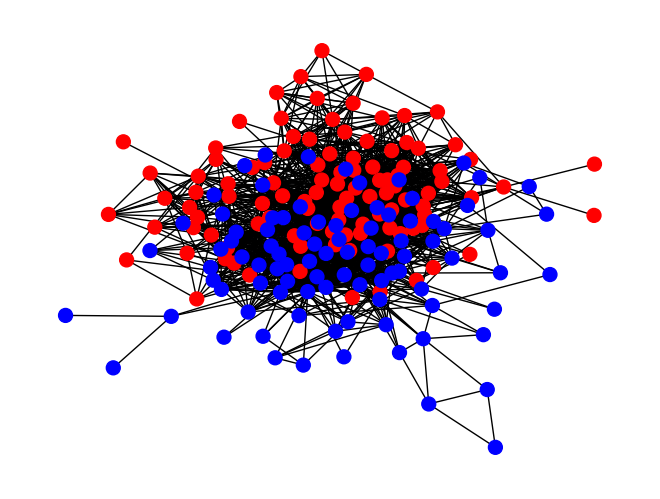

In [12]:

# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in graph2.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos, node_size=100, node_color=colors)

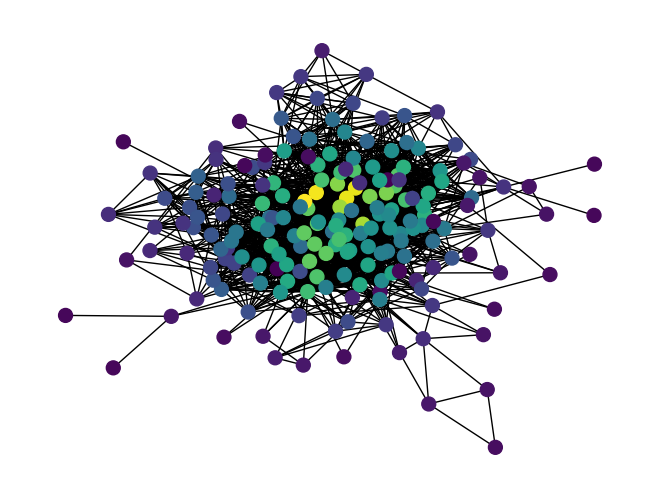

In [13]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph2)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos, node_size=100, node_color=color_map)

In [14]:
# Get our graph metrics
v1_graph_eval = graph_scoring.quick_stats(graph2)

v1_graph_eval

Calculating quick stats


{'number_of_nodes': 197,
 'number_of_edges': 2122,
 'average_degree': 21.543147208121827,
 'density': 0.1099140163679685,
 'clustering_coefficient': 0.6277666244268248}

In [15]:
try:
    v1_graph_eval['communities']
    
    community_node_list = v1_graph_eval['communities']

    # Split viridis into n colors
    n = len(community_node_list)
    viridis = mpl.colormaps['viridis']
    colors = [viridis(i/n) for i in range(n)]

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in graph2.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(graph2)
    nx.draw(graph2, pos, node_size=100, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", v1_graph_eval['community_modularity'])
    
except KeyError:
    pass

# V3 algorithm Graph Eval


In [3]:
v3_test = v3.V3Retriever()

adj_dict = v3_test.construct_adjacency_dict(embed_index=embedded_index)

Calculating distance vectors: 100%|██████████| 197/197 [00:39<00:00,  5.05it/s]


In [4]:
# Identify the min and max of adj_dict
val_list = []
for k, v in adj_dict.items():
    for k, v in v.items():
        val_list.append(v['weight'])
        
min(val_list), max(val_list)

(0.0, 1.0)

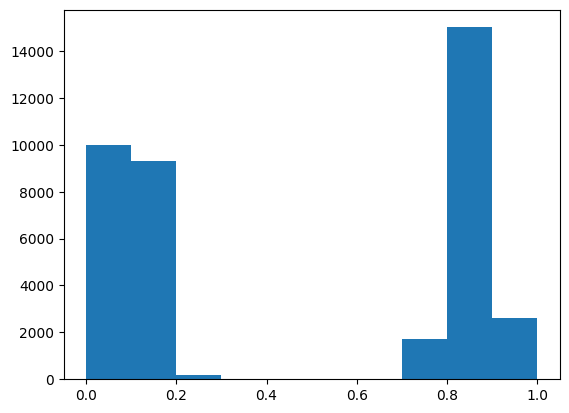

In [5]:
# Plot the distribution of edge weights
import matplotlib.pyplot as plt

plt.hist(val_list)
plt.show()

In [27]:
v3_graph = graph_construction.construct_graph_from_adj_dict(adj_dict, 0.9, embedded_index)

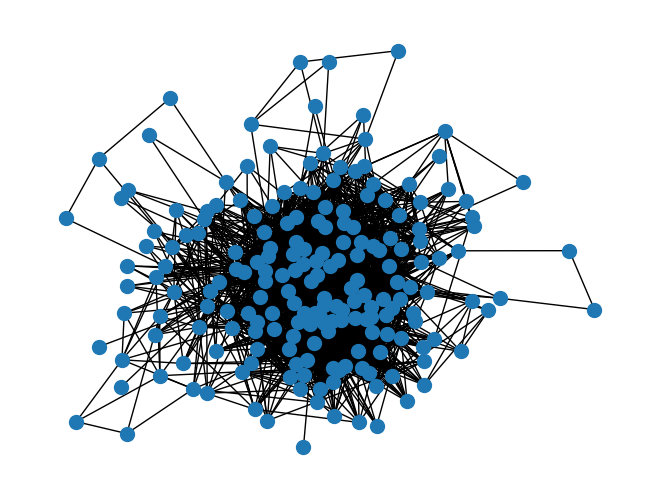

In [30]:
pos_test_G = nx.kamada_kawai_layout(v3_graph)
nx.draw(v3_graph, pos_test_G, node_size=100)

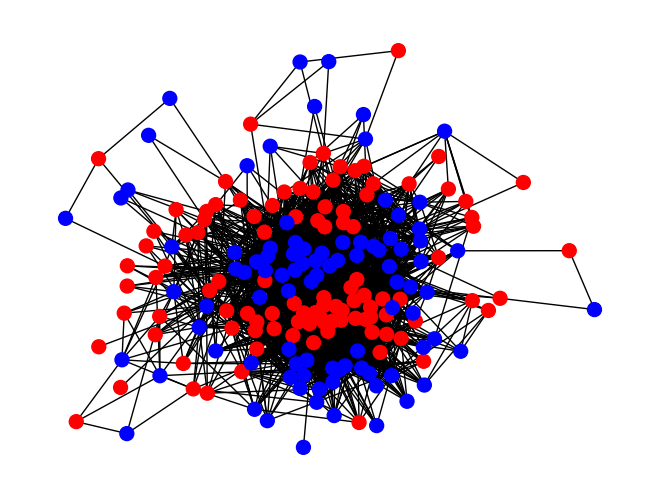

In [31]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in v3_graph.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(v3_graph)
nx.draw(v3_graph, pos, node_size=100, node_color=colors)

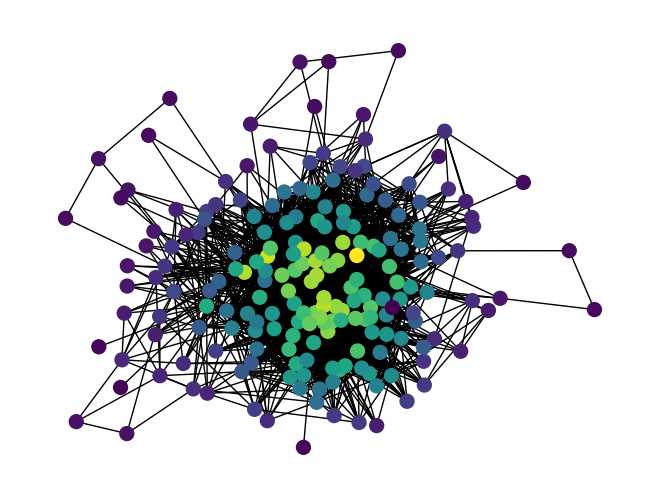

In [33]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(v3_graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in v3_graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(v3_graph)
nx.draw(v3_graph, pos, node_size=100, node_color=color_map)

In [35]:
# Get our graph metrics
v3_graph_eval = graph_scoring.quick_stats(v3_graph)

v3_graph_eval

Calculating quick stats


{'number_of_nodes': 197,
 'number_of_edges': 2545,
 'average_degree': 25.83756345177665,
 'density': 0.13182430332539108,
 'clustering_coefficient': 0.0}

In [36]:
try:
    v3_graph_eval['communities']
    
    community_node_list = v3_graph_eval['communities']

    # Split viridis into n colors
    n = len(community_node_list)
    viridis = mpl.colormaps['viridis']
    colors = [viridis(i/n) for i in range(n)]

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in v3_graph.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(v3_graph)
    nx.draw(v3_graph, pos, node_size=100, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", v3_graph_eval['community_modularity'])
    
except KeyError:
    pass

# V4 algorithm Graph Eval

In [4]:
v4_test = v4.V4Retriever(embedded_index=embedded_index)

In [5]:
v4_test.calculate_distance(embedded_index[0], embedded_index[1])

20.83558553282082

In [25]:
sub_index = random.sample(embedded_index, 80)

#### Performance optimisation

This thing takes way too long right now...

In [25]:
%timeit embedded_index[0].text.split()

210 ns ± 23.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [27]:
from nltk.tokenize import word_tokenize
%timeit word_tokenize(embedded_index[0].text)

40.8 µs ± 1.42 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [24]:
import re
%timeit re.findall(r'\b\w+\b', embedded_index[0].text)

1.32 µs ± 19.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [7]:
%prun graph_construction.construct_adjacency_dict(sub_index, v4.V4Retriever(embedded_index=sub_index))

Constructing adjacency dict: 100%|██████████| 20/20 [00:02<00:00,  6.99it/s]

         6211354 function calls in 2.862 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      400    1.283    0.003    1.884    0.005 fastbm25.py:143(get_score_by_reversed_index_all_documents)
      400    0.646    0.002    0.708    0.002 fastbm25.py:71(_initialize)
  2666000    0.473    0.000    0.477    0.000 {built-in method builtins.round}
  2054482    0.120    0.000    0.120    0.000 {method 'update' of 'dict' objects}
     8800    0.086    0.000    0.086    0.000 {method 'split' of 'str' objects}
  1224000    0.058    0.000    0.058    0.000 {built-in method math.log}
      400    0.054    0.000    2.790    0.007 v4.py:56(calculate_distance)
      400    0.046    0.000    0.051    0.000 fastbm25.py:110(similarity_bm25)
     1579    0.045    0.000    0.045    0.000 {method 'acquire' of '_thread.lock' objects}
      571    0.007    0.000    0.007    0.000 socket.py:621(send)
      400    0.006    0.000    2.736    0.00

#### Actually do this

In [26]:
# Construct the adj dict
adj_dict = graph_construction.construct_adjacency_dict(sub_index, v4.V4Retriever(embedded_index=sub_index))

Constructing adjacency dict: 100%|██████████| 80/80 [02:01<00:00,  1.51s/it]


In [33]:
norm_adj_dict = v4_test.normalise_adj_dict(adj_dict)

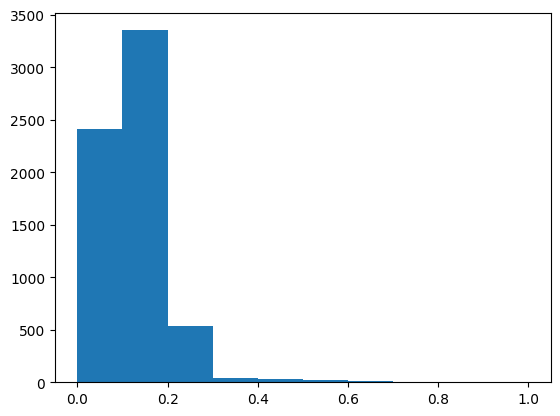

In [34]:
# Histogram of the weights
normed_weights = []
for doc in norm_adj_dict.keys():
    for doc2 in norm_adj_dict[doc].keys():
        normed_weights.append(norm_adj_dict[doc][doc2]['weight'])
        
        
plt.hist(normed_weights)
plt.show()

In [35]:
v4_graph = graph_construction.construct_graph_from_adj_dict(norm_adj_dict, 0.17, embedded_index)

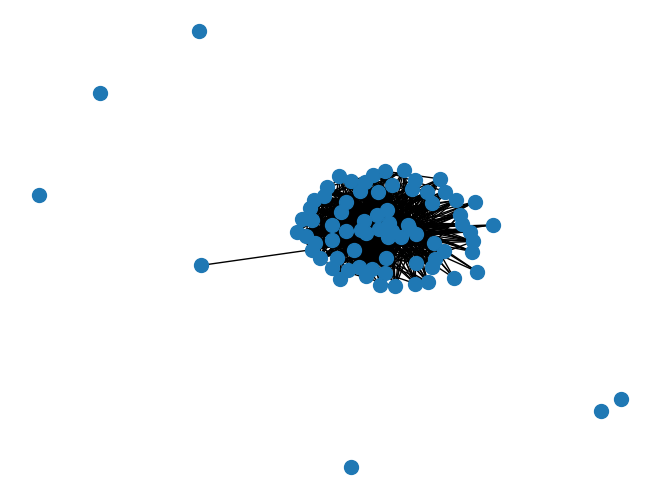

In [36]:
pos_test_G = nx.kamada_kawai_layout(v4_graph)
nx.draw(v4_graph, pos_test_G, node_size=100)

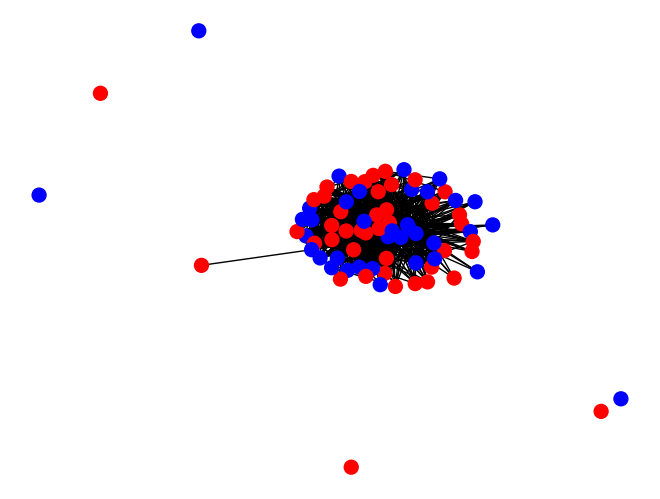

In [37]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in embedded_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in v4_graph.nodes:
    for doc in embedded_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(v4_graph)
nx.draw(v4_graph, pos, node_size=100, node_color=colors)

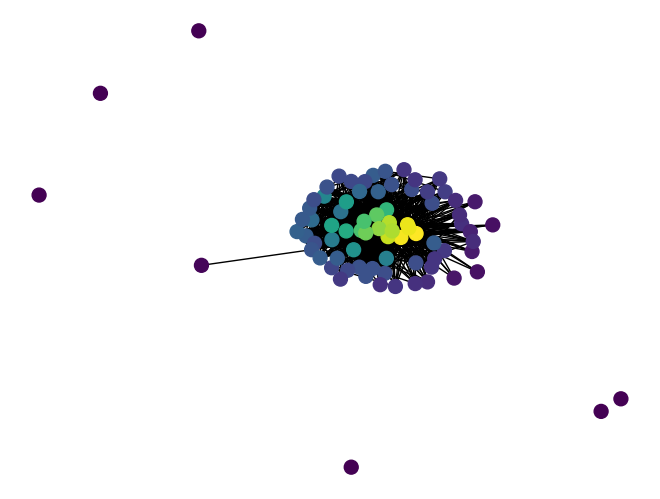

In [38]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(v4_graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in v4_graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(v4_graph)
nx.draw(v4_graph, pos, node_size=100, node_color=color_map)

In [39]:
# Get our graph metrics
v4_graph_eval = graph_scoring.quick_stats(v4_graph)

v4_graph_eval

Calculating quick stats


{'number_of_nodes': 80,
 'number_of_edges': 918,
 'average_degree': 22.95,
 'density': 0.29050632911392404,
 'clustering_coefficient': 0.7660051175206494}

In [40]:
try:
    v4_graph_eval['communities']
    
    community_node_list = v4_graph_eval['communities']

    # Split viridis into n colors
    n = len(community_node_list)
    viridis = mpl.colormaps['viridis']
    colors = [viridis(i/n) for i in range(n)]

    # Create a dictionary that maps each community to a color
    community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

    node_colors = []

    for node in graph2.nodes:
        # Find which community the node belongs to
        for community, color in community_color_dict.items():
            if node in community:
                node_colors.append(color)

    # Draw the graph with the communities colored
    pos = nx.kamada_kawai_layout(graph2)
    nx.draw(graph2, pos, node_size=100, node_color=node_colors)

    # Print the modularity of the partition
    print("The modularity of this method is:", v4_graph_eval['community_modularity'])
    
except KeyError:
    pass